<a href="https://colab.research.google.com/github/Siddharthgolecha/HighQ/blob/add_colab_notebook/QOSF_Mentorship_Task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qiskit
!pip install torch
!pip install pennylane

     |████████████████████████████████| 6.1 MB 5.3 MB/s 
     |████████████████████████████████| 17.9 MB 109 kB/s 
     |████████████████████████████████| 235 kB 56.3 MB/s 
     |████████████████████████████████| 207 kB 52.0 MB/s 
     |████████████████████████████████| 2.1 MB 47.4 MB/s 
     |████████████████████████████████| 200 kB 52.5 MB/s 
     |████████████████████████████████| 634 kB 53.1 MB/s 
     |████████████████████████████████| 1.4 MB 52.0 MB/s 
     |████████████████████████████████| 52 kB 1.3 MB/s 
     |████████████████████████████████| 943 kB 49.9 MB/s 
     |████████████████████████████████| 38.2 MB 26 kB/s 
     |████████████████████████████████| 49 kB 5.6 MB/s 
     |████████████████████████████████| 3.0 MB 37.1 MB/s 
     |████████████████████████████████| 6.3 MB 51.2 MB/s 
  Created wheel for qiskit: filename=qiskit-0.30.0-py3-none-any.whl size=11273 sha256=5dbdbbdc7a4874779d627d373b1867216fb3b2eb539dc8844be401f5ba74a975
  Stored in directory: /root/.cache/pip/whe

In [171]:
import qiskit
import numpy as np
import torch
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer
from qiskit.tools.visualization import plot_histogram
from torch.autograd import Function
from qiskit.visualization import *
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.optim import Optimizer

In [241]:
class TrainingData:

  def __init__(self,n, size, backend=Aer.get_backend('qasm_simulator'),
               shots=1024):
    self.n = n
    self.backend = backend
    self.shots = shots
    self.size = size
    self.n_params = None
    counts = self.generate_sample(self.n, self.backend, self.shots)
    counts = dict(sorted(counts.items(), 
                         key=lambda item: item[1]))
    self.samples = list(counts.keys())[:self.size]

  def generate_sample(self,n,backend,shots):
    circuit = QuantumCircuit(n,n)
    for i in range(n):
      args = np.random.rand(3)*2*np.pi
      circuit.u(args[0], args[1], args[2], i)
      circuit.measure(i,i)
    result = backend.run(circuit, shots=shots).result()
    counts = result.get_counts()
    return counts

  def to_params(self, n_params=None):
    if n_params is None:
      if n_params == self.n_params:
        raise ValueError("Add the number of paramters to convert")
      else:
        self.n_params = n_params
    self.params = np.zeros((self.size,n_params))
    for index in range(self.size):
      sample = self.samples[index]
      for i in range(self.n):
        state = sample[i]
        if state=="1":
          self.params[index][self.n-i-1] = np.pi/2
    return self.params

  def __str__(self):
    return str(self.samples)

In [240]:
class Labels:

  def __init__(self, data):
    self.data = data
    self.size = len(data)
    self.n = len(data[0])
    self.n_params = None

  def to_params(self, n_params=None):
    if n_params is None:
      if n_params == self.n_params:
        raise ValueError("Add the number of paramters to convert")
      else:
        self.n_params = n_params
    self.params = np.zeros((self.size,n_params))
    for index in range(self.size):
      sample = self.data[index]
      for i in range(self.n):
        state = sample[i]
        if state=="1":
          self.params[index][self.n-i-1] = np.pi/2
    return self.params

  def tensor(self):
    return torch.tensor([int(data,2) for data in self.data])
  def __str__(self):
    return str(self.data)

In [316]:
class QNNCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit for training
    """
    
    def __init__(self, kernel_size,
                 backend=Aer.get_backend('qasm_simulator'),
                 shots = 1024):
        # --- Circuit definition ---
        self.kernel_size = kernel_size
        self.output_qubits = QuantumRegister(kernel_size, name="output")
        self.training_qubits = QuantumRegister(kernel_size, name="training")
        self.data_qubits = QuantumRegister(kernel_size, name="data")
        self.measuring_register = ClassicalRegister(kernel_size, "meas")
        # ---------------------------
        self.backend = backend
        self.shots = shots
        self.count = None
    
    def create_circuit(self, thetas, X):
      if len(thetas) != len(X):
        raise ValueError("Expected length of X is {} but received {}".format(
            len(thetas), len(X)
        ))
      if isinstance(thetas, np.ndarray):
        thetas = thetas.tolist()
      if isinstance(X, np.ndarray):
        X = X.tolist()
      self.circuit = QuantumCircuit(self.training_qubits,
                                    self.data_qubits,
                                    self.output_qubits)
      for i in range(len(thetas)):
        if (i//self.kernel_size)%self.kernel_size == 0:
          self.circuit.ry(thetas[i], 
                          self.training_qubits[i%self.kernel_size])
          self.circuit.ry(X[i], self.data_qubits[i%self.kernel_size])
        else:
          self.circuit.rz(thetas[i], 
                          self.training_qubits[i%self.kernel_size])
          self.circuit.rz(X[i], self.data_qubits[i%self.kernel_size])
        
      self.circuit.cx(self.training_qubits, self.output_qubits)
      self.circuit.cx(self.data_qubits, self.output_qubits)
        
    def expval(self):
      self.expvalue = 0
      if self.count is None:
        self.get_training_states()
      for key,val in self.count.items():
        self.expvalue += int(key,2)*val
      return self.expvalue

    def get_training_states(self):
      self.circuit.add_register(self.measuring_register)
      self.circuit.measure(self.output_qubits,
                                 self.measuring_register)
      job = self.backend.run(self.circuit, shots=self.shots)
      counts = job.result().get_counts()
      self.count = {key: val/self.shots for key, val in counts.items()}
      return self.count

In [165]:
def get_accuracy(pred, actual):
  return pred[int(actual,2)]

In [102]:
def hotshot(counts, size):
  new_count = []
  for i in range(size*size):
    key = "{0:b}".format(i).zfill(size)
    if key in counts:
      new_count.append(counts[key])
    else:
      new_count.append(0.0)
  return new_count

In [11]:
def paramList_to_numpy(params):
  new_params = np.array([ for param in params])
  return new_params

In [294]:
class QNNModel(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self,kernel_size, data,
                 backend = Aer.get_backend('qasm_simulator'),
                 shots = 1024, n_params = 8, shift = 0.01):
        super(QNNModel, self).__init__()
        self.backend = backend
        self.kernel_size = kernel_size
        self.shots = shots
        self.shift = shift
        self.data_size = len(data.samples)
        self.n_params = n_params
        self.param = nn.Parameter(torch.rand(self.n_params,
                                              requires_grad=True)*np.pi)
        
    def forward(self, data, state):
        self.quantum_circuit = QNNCircuit(self.kernel_size)
        self.data = data
        param = self.param.data.numpy()
        data_params = data.to_params(self.n_params)
        self.quantum_circuit.create_circuit(param, data_params[state])
        return torch.tensor(
            hotshot(self.quantum_circuit.get_training_states(), 
                    self.kernel_size),requires_grad = True)

In [291]:
class QuantumOptimizer(Optimizer):

  def __init__(self, param, size, lr = 0.01, shift = np.pi/2):
    self.param = param
    self.shift = shift
    self.size = size
    self.lr = lr
    self.state_params = None
  
  @torch.no_grad()
  def step(self, closure=None):
    loss = None
    if closure is not None:
      with torch.enable_grad():
        loss = closure()
    input_list = self.param.numpy()
    gradients = []
    fwd_shift = input_list + np.identity(self.size) * self.shift
    back_shift = input_list - np.identity(self.size) * self.shift
    fwd_circuit = [QNNCircuit(self.size) for i in range(self.size)]
    back_circuit = [QNNCircuit(self.size) for i in range(self.size)]

    for i in range(self.size):
      fwd_circuit[i].create_circuit(fwd_shift[i], self.state_params)
      back_circuit[i].create_circuit(back_shift[i], self.state_params)
      gradient = 0.5*(-np.log(fwd_circuit[i].expval()) + 
                      np.log(back_circuit[i].expval()))
      gradients.append(gradient)
    
    gradients = torch.tensor(gradients, dtype=torch.float64)
    self.param -= gradients*self.lr
    return loss

In [274]:
def ExpvalLoss(circuits):
  return torch.mean(torch.tensor([circuits[i].expval()
  for i in range(len(circuits))], requires_grad=True))

In [281]:
random_states = TrainingData(4, size=4)
labels = Labels(['0011', '0101', '1010', '1100'])
print(random_states)

['1100', '1000', '1001', '1101']


In [293]:
model= QNNModel(kernel_size=4, data=random_states, n_params=8)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = QuantumOptimizer(model.param, 
                             size = model.n_params,shift=np.pi/2)
criterion = ExpvalLoss
epochs = 25
tune_epochs = model.n_params
loss_list = []
accuracy_list = []
label_params = labels.to_params(model.n_params)

model.train()
for epoch in range(1,epochs+1):
  print('Epoch {:03d}'.format(epoch))
  state_loss = []
  state_accuracy = []
  for state in range(labels.size):
    loss_sum = 0
    for t in range(tune_epochs):
      # Forward pass
      output = model(labels, state)
      #print(output)
      # Calculating loss
      loss = torch.tensor(model.quantum_circuit.expval(),
                          requires_grad = True)
      loss.backward()
      loss_sum += loss.item()
      # Optimize the weights
      optimizer.state_params = label_params[state]
      optimizer.shift = np.pi/(2*np.sqrt(epoch))
      optimizer.step()
    state_loss.append(loss_sum/tune_epochs)
    state_accuracy.append(get_accuracy(output, labels.data[state]))
    print('State {}\tTraining Loss: {:.4f}\tTraining Accuracy: {:.4f}\t'.
          format(labels.data[state], state_loss[-1], state_accuracy[-1]))
  loss_list.append(state_loss)
  accuracy_list.append(state_accuracy)

Epoch 001
State 0011	Training Loss: 0.4943	Training Accuracy: 0.1455	
State 0101	Training Loss: 0.4928	Training Accuracy: 0.0049	
State 1010	Training Loss: 0.4836	Training Accuracy: 0.0234	
State 1100	Training Loss: 0.4796	Training Accuracy: 0.0586	
Epoch 002
State 0011	Training Loss: 0.4917	Training Accuracy: 0.1289	
State 0101	Training Loss: 0.4956	Training Accuracy: 0.0049	
State 1010	Training Loss: 0.4891	Training Accuracy: 0.0195	
State 1100	Training Loss: 0.4821	Training Accuracy: 0.0527	
Epoch 003
State 0011	Training Loss: 0.4963	Training Accuracy: 0.1504	
State 0101	Training Loss: 0.4932	Training Accuracy: 0.0039	
State 1010	Training Loss: 0.4890	Training Accuracy: 0.0264	
State 1100	Training Loss: 0.4958	Training Accuracy: 0.0576	
Epoch 004
State 0011	Training Loss: 0.4963	Training Accuracy: 0.1377	
State 0101	Training Loss: 0.4962	Training Accuracy: 0.0029	
State 1010	Training Loss: 0.5079	Training Accuracy: 0.0244	
State 1100	Training Loss: 0.4921	Training Accuracy: 0.0674	


KeyboardInterrupt: ignored

In [285]:
loss_list = np.array(loss_list)
accuracy_list = np.array(accuracy_list)

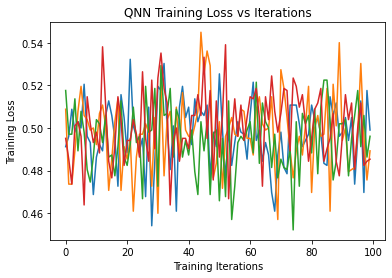

In [286]:
plt.plot(loss_list)
plt.title('QNN Training Loss vs Iterations')
plt.xlabel('Training Iterations')
plt.ylabel('Training Loss')
plt.show()

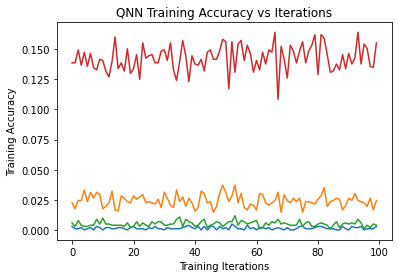

In [287]:
plt.plot(accuracy_list)
plt.title('QNN Training Accuracy vs Iterations')
plt.xlabel('Training Iterations')
plt.ylabel('Training Accuracy')
plt.show()

In [290]:
model.eval()
with torch.no_grad():

  for state in range(labels.size):
    output = model(random_states, state)
    output = {"{0:b}".format(key).zfill(labels.n):output[key] 
              for key in range(len(output))}
    out_state = max(output, key = lambda x: output[x])
    print("Actual Label = {}\tOutput Label = {}".format(
        labels.data[state], out_state))
    print("Actual Label Probabilty = {:.2f}%".format(
        output[labels.data[state]]*100))

Actual Label = 0011	Output Label = 0100
Actual Label Probabilty = 0.00%
Actual Label = 0101	Output Label = 0000
Actual Label Probabilty = 2.83%
Actual Label = 1010	Output Label = 0100
Actual Label Probabilty = 0.39%
Actual Label = 1100	Output Label = 0100
Actual Label Probabilty = 13.09%
